## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [136]:
!pip install torch torchvision

In [137]:
!git clone https://github.com/parth1620/Project-NST.git

fatal: destination path 'Project-NST' already exists and is not an empty directory.


## Task 2 : Loading VGG Pretrained Model

In [138]:
import torch
from torchvision import models
vgg = models.vgg19(pretrained = True)

In [139]:
vgg_model = vgg.features

In [140]:
for param in vgg_model.parameters():
  param.requires_grad_(False)

In [141]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [142]:
vgg_model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [143]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size=500):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  img_transforms = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(), #(H, W , C) -> (C, H , W)
            T.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)
  image = image.unsqueeze(0)  #(C, H, W) -> (1, C, H, W)

  return image

In [144]:
content_preprocessed = preprocess('/content/Project-NST/content11.jpg').to(DEVICE)
style_preprocessed = preprocess('/content/Project-NST/style12.jpg').to(DEVICE)

print(f'content shape: {content_preprocessed.shape} and style shape: {style_preprocessed.shape}')

content shape: torch.Size([1, 3, 259, 259]) and style shape: torch.Size([1, 3, 500, 500])


## Task 4 : Deprocess image

In [145]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) #(1, C, H, W) -> (C, H, W)
  image = image.transpose(1,2,0) #(C, H , W) -> (H, W , C)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image

In [146]:
content_d = deprocess(content_preprocessed)
style_d = deprocess(style_preprocessed)

print(f'content shape: {content_d.shape} and style shape: {style_d.shape}')

content shape: (259, 259, 3) and style shape: (500, 500, 3)


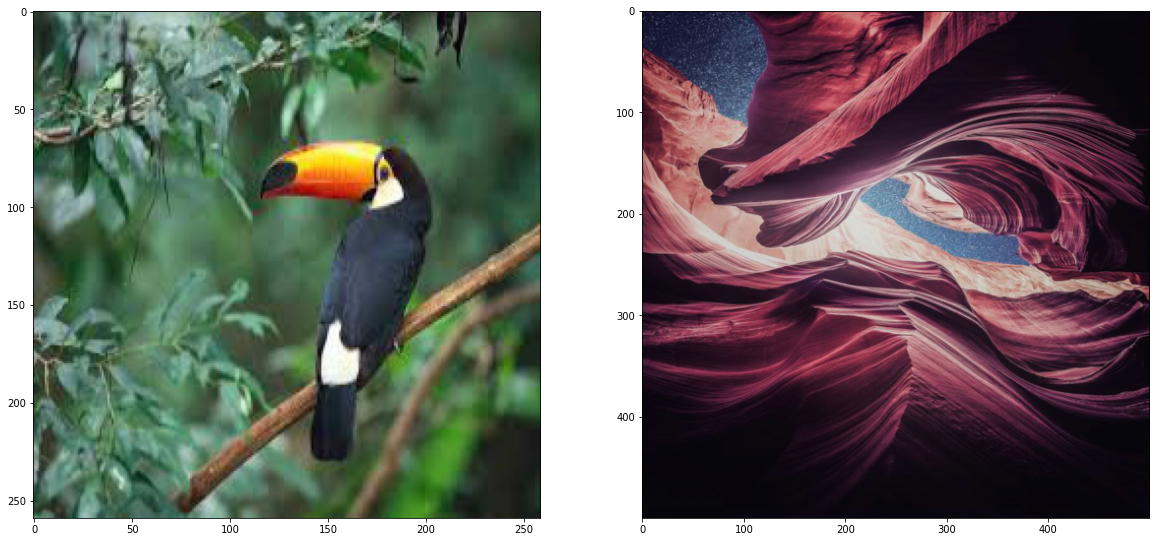

In [147]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

In [148]:
for name, layer in vgg_model._modules.items():
  print(f'name: {name} and layer: {layer}\n')

name: 0 and layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 1 and layer: ReLU(inplace=True)

name: 2 and layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 3 and layer: ReLU(inplace=True)

name: 4 and layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

name: 5 and layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 6 and layer: ReLU(inplace=True)

name: 7 and layer: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 8 and layer: ReLU(inplace=True)

name: 9 and layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

name: 10 and layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 11 and layer: ReLU(inplace=True)

name: 12 and layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

name: 13 and layer: ReLU(inplace=True)

name: 14 and layer: Conv2d(256, 256, kernel_size=(

In [149]:
def get_features(image, model):

  layers= {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19': 'conv4_1',
      '21' : 'conv4_2',
      '28' : 'conv5_1'
  }

  x = image

  Features = {}

  for name,layer in model._modules.items():
    x = layer(x)

    if name in layers:
      Features[layers[name]] = x


  return Features


In [150]:
content_f = get_features(content_preprocessed, vgg_model)
style_f = get_features(style_preprocessed, vgg_model)

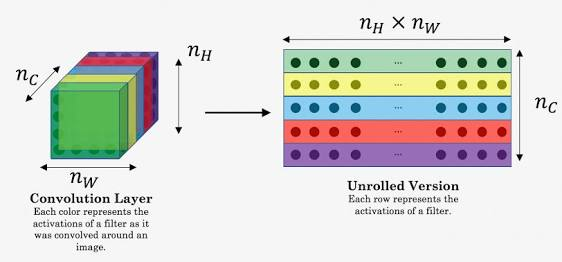

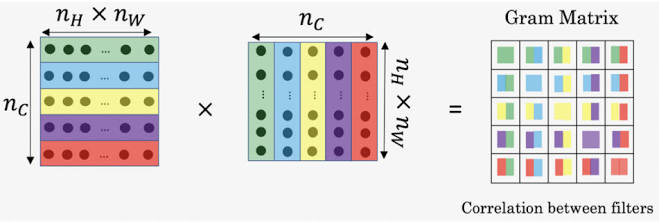

In [151]:
def gram_matrix(tensor):
  b,c,h,w = tensor.shape
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor, tensor.T)
  return gram

In [152]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [153]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [154]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1': 0.75,
    'conv3_1' : 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [160]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0.0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

    loss += layer_loss/ (c*h*w)
  return loss

In [156]:
target = content_preprocessed.clone().requires_grad_(True).to(DEVICE)
target_f = get_features(target, vgg_model)
content_l = content_loss(target_f['conv4_2'], content_f['conv4_2'])
style_loss = style_loss(style_weights, target_f, style_grams)
print(f'Content loss: {content_loss}')
print(f'style loss: {style_loss}')

Content loss: <function content_loss at 0x7faa24f564d0>
style loss: 1685.045166015625


## Task 7 : Training loop

In [157]:
from torch import optim
opt = optim.Adam([target], lr=0.001)

alpha = 1
beta = 1e5

epochs= 3000
show_every = 500

In [158]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [164]:
result = []

for i in range(epochs):

  target_f = get_features(target, vgg_model)
  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss =total_loss(c_loss, s_loss, alpha, beta)

  opt.zero_grad()
  t_loss.backward()
  opt.step()

  if i % show_every == 0:
    print(f'Ecpoch[{i}] ->  loss: {t_loss}')
    result.append(deprocess(target.detach()))

Ecpoch[0] ->  loss: 13537969.0
Ecpoch[500] ->  loss: 12015325.0
Ecpoch[1000] ->  loss: 10794261.0
Ecpoch[1500] ->  loss: 9778070.0
Ecpoch[2000] ->  loss: 8917523.0
Ecpoch[2500] ->  loss: 8181751.5


<function matplotlib.pyplot.show>

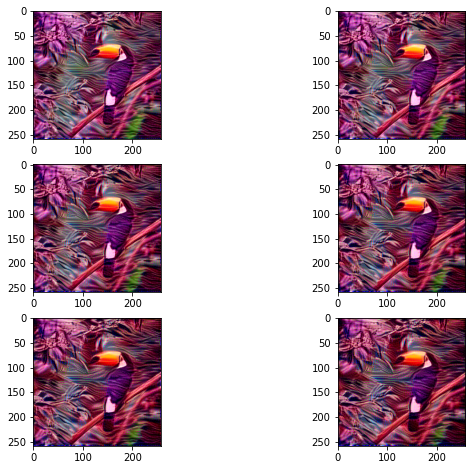

In [165]:
plt.figure(figsize = (10,8))

for i in range(len(result)):
  plt.subplot(3,2, i+1)
  plt.imshow(result[i])

plt.show


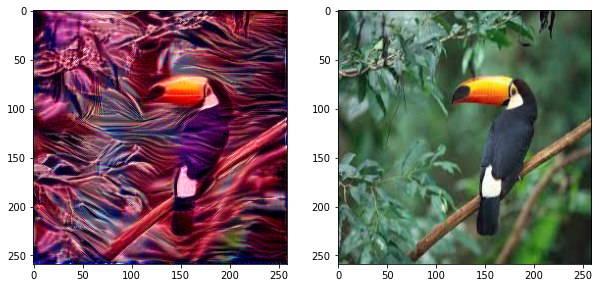

In [166]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocessed)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)

In [ ]:
while